# The LIBOR Forward Market Model (LFMM)

LFMM models the simple forward rates in the market.

The forward rate between times $t_j$ and $t_{j+1}$ is:<br>
$F(t,T_j, T_{j+1}) = F_j(t)$

The differential between the two dates:<br>
$\delta_j = T_{j+1} - T_j$

The LFMM says that each market forward rate has the following SDE:
    $$ dF_j(t) = F_j(t)\mu_j(t)dt + F_j(t) \sigma_j (t) dW_t$$
   
where,
$\mu_j (t)$ is the time dependent drift associated with $F_j (t)$ <br>
$\sigma_j (t)$ is the time dependent vol associated with $F_j (t)$ <br>
$dW_t$ is a Brownian motion

### Assumptions
We will assume one Brownian motion for every forward rate in the market. 
We can later include multiple Brownians for Variance, Covariance, Correlation.

### Time dependent drift 
The $\mu (t)$ in the above equation can be written as:
$$ \mu (t) = \sum_{k=\tau(t)}^{j} \frac{\delta_k F_k(t) \sigma_k(t) \sigma_j(t)}{1 + \delta_k F_k(t)}$$

where, 
$\tau(t) = \min \{ i:t < T_i \}$

### Approximate solutions
It can be shown that the approximation for the $j^{th}$ forward rate at the time $t_i$ is:
$$\hat{F}_j(t_i) = \hat{F}_j(t_{i-1}) e^{\big[\hat{\mu}_j(t_{i-1}) - \frac{1}{2}\sigma^2)\delta_{i-1} + \sigma_j \sqrt{\delta_{i-1}}Z_i \big]}$$

where, <br>
$\hat{F}_j(t_i)$ is the approximation for the $j^{th}$ forward rate at the time $t_i$ <br>
$Z \approx N(0,1)$<br>
$ \hat{\mu}_j (t_{i-1}) = \sum_{k=1}^{j} \frac{\delta_k \hat{F}_j(t_{i-1}) \sigma_k \sigma_j}{1 + \delta_k \hat{F}_j(t_{i-1})}$





To apply monte-carlo simulations, we need initial values for $\hat{F}_j(t_i) = F_j (t_0)$, <br>
where, <br>
$ F_j (t_0)$ are 
* implied from market zcb prices and 
* the following formula: $F_j(t_0) = \frac{P_j(0) - P_{j+1}(0)}{\delta_0 P_{j+1}(0)}$

## Predictor-Corrector Method 


The Predictor-Corrector Method is used to improve the overall accruacy of the forward rate approximations. We can use this method that revolves around estimating an initial and a terminal drift, then using an average of these to project future forward rates.

Initialise
$$\hat{F}_j(t_0) = F_j (t_0)$$

Estimate Forward Rate for the next period
$$ \tilde{F}_j(t_i) = \bar{F}_j(t_{i-1}) e^{\big[\mu^1_j(t_{i-1}) - \frac{1}{2}\sigma^2)\delta_{i-1} + \sigma_j \sqrt{\delta_{i-1}}Z_i \big]}$$
where, <br>
* $\mu^1_j (t) = \sum_{k=1}^{j} \frac{\delta_k \bar{F}_j(t_{i-1}) \sigma_k \sigma_j}{1 + \delta_k \bar{F}_j(t_{i-1})}$
* $\mu^2_j (t_{i-1}) = \sum_{k=1}^{j} \frac{\delta_k \tilde{F}_j(t_{i-1}) \sigma_k \sigma_j}{1 + \delta_k \tilde{F}_j(t_{i-1})} $

Final step is to compute the final estimate for the forward rate in the next period using:

$$ \bar{F}_j(t_i) = \bar{F}_j(t_{i-1}) e^{\big[\frac{1}{2}(\mu^1_j(t_{i-1}) + \mu^2_j(t_{i-1}) - \sigma^2)\delta_{i-1} + \sigma_j \sqrt{\delta_{i-1}}Z_i \big]}$$

## Simulating Bond Prices in Python
1. simulating forward rates
2. using these to imply capitalisation factors
3. then inverting these to imply discount factors which should be equal to the bond price under no arbitrage.

In [11]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

In [14]:
# parameters
r0 = 0.02
alpha = 0.2
b = 0.05
sigma = 0.025

In [15]:
# bond maturities are 2 years apart
t = np.linspace(0,50,21)
sigmaj = 0.1

$\sigma_j$ is the volatility for the LFMM model

### Generate Bond Prices Using Vasicek Dynamics
For a real world application, we would use market prices instead of simulating prices like we are right now.

In [16]:
# Analytical Bond price
def A(t1, t2):
    return (1-np.exp(-alpha*(t2-t1)))/alpha

def C(t1, t2):
    val_1 = (t2-t1-A(t1,t2))*(sigma**2/(2*alpha**2)-b)
    val_2 = sigma**2*A(t1,t2)**2/(4*alpha)
    return val_1 - val_2

def bond_price(r,t,T):
    return np.exp(-A(t,T)*r + C(t,T))

vasi_bond = bond_price(r0,0,t)

In [17]:
np.random.seed(0)
n_simulations = 100000

#stores the number of time steps we are simulating over 
n_steps = len(t)

#Initialize the forward rates by multipyling a matrix of ones by the forward rates at time t0 implied by the bond prices

mc_forward = np.ones([n_simulations,n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(2*vasi_bond[1:])
predcorr_forward = np.ones([n_simulations,n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(2*vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations,n_steps])
mc_capfac = np.ones([n_simulations,n_steps])

#store the time increments bewteen bond maturities
delta = np.ones([n_simulations,n_steps-1])*(t[1:]-t[:-1])

In [18]:
for i in range(1,n_steps):
    Z = norm.rvs(size = [n_simulations,1])
    
    # Explicit Monte Carlo simulation
    muhat = np.cumsum(delta[:,i:]*mc_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*mc_forward[:,i:]),axis = 1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    # Predictor-Corrector
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]),axis = 1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp),axis = 1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)

We have completed step number 1, ie, simulating forward rates. <br>
Now, we need capitalisation factors:
$$ C(t_0, t_n) = \Pi_{k=1}^{n} (1 + \delta_k F_k(t_k))$$

where,
$ C(t,T)$ is capitalisation factor for the period $t_0$ and $t_n$. <br>

We then take the inverse of the capitalisation factors to get the bond prices (same as the discount factors) and take the mean.

In [19]:
# Implying capitalisation factors from the forward rates
mc_capfac[:,1:] = np.cumprod(1+delta*mc_forward, axis = 1)
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward, axis = 1)

# Inverting the capitalisation factors to imply bond prices (discount factors)
mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

# Taking averages
mc_final = np.mean(mc_price,axis = 0)
predcorr_final = np.mean(predcorr_price,axis = 0)

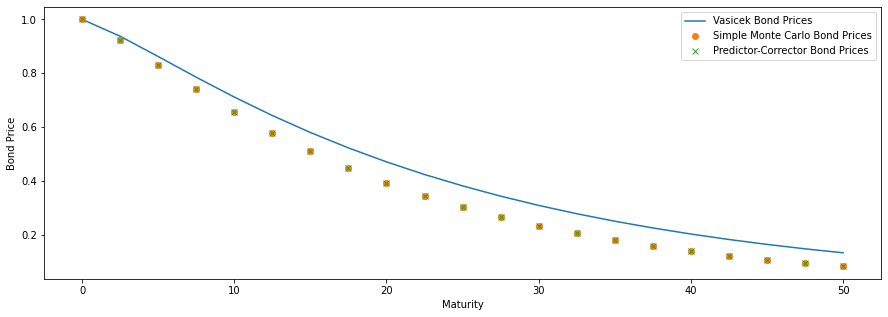

In [20]:
plt.figure(figsize=(15,5))
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t, vasi_bond, label="Vasicek Bond Prices")
plt.plot(t, mc_final, "o", label="Simple Monte Carlo Bond Prices")
plt.plot(t, predcorr_final, "x", label="Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

## References
* quantpie.co.uk, "LIBOR Market Model", https://www.youtube.com/watch?v=vbtkyczmy60
* Hunter, C,J (2001), "Drift apporximations in a forward rate based LIBOR market model", Getting the Drift
* UCT Pigeons, "An Assessment on the Appropriateness of the use of the LFMM in South Africa", https://people.math.ethz.ch/~yuxi/Xi_FMTCJul18.pdf
* WQU notes, Computational Finance